In [84]:
# 必要なパッケージを読み込む
using DelimitedFiles, DataFrames,  Plots
Plots.default(fontfamily="IPAexGothic")
# 前提として、以下のファイルが既に存在している
include("calc_IPW.jl")          # リグレット計算の基本関数
include("file_operate.jl")      # ファイル操作用関数
include("module_regret.jl") # 先ほど定義した新しいモジュール

# RankChangeIntervalモジュールを使用
using .RankChangeInterval



In [85]:
# 1. データの読み込み
function load_data(method_name="simp", repeat_num=1, criteria_num=6)
    # 効用値行列の読み込み
    utility_data = read_utility_value()[5]  # 最初のデータセットを使用
    
    # 区間重要度の読み込み
    method_weights = read_method_weights(method_name, repeat_num, criteria_num)[1]
    
    return utility_data, method_weights
end

# 2. 最適なtの範囲を計算
function calculate_t_range(method_weights)
    t_range = find_optimal_trange(method_weights.L, method_weights.R)
    println("最適t範囲: [", t_range[1], ", ", t_range[2], "]")
    return t_range
end


calculate_t_range (generic function with 1 method)

In [86]:
# 3. アベイルスペースに基づく順位変化点を分析
function analyze_rank_changes(utility_data, method_weights, t_range)
    utility_matrix = Matrix(utility_data)
    results = RankChangeInterval.analyze_all_alternatives_with_avail_space(utility_matrix, method_weights, t_range)
    println(results)
    
    println("検出された傾き変化区間:")
    for (i, interval) in enumerate(results.intervals)
        println("  区間 $i: [", interval[1], ", ", interval[2], "]")
    end
    
    println("\n順位変化点:")
    for (i, t) in enumerate(results.change_points)
        println("  変化点 $i: t = $t")
    end
    
    println("\n各時点での順位:")
    for t in sort(collect(keys(results.rankings)))
        println("  t = $t: ", results.rankings[t])
    end
    
    return results
end


analyze_rank_changes (generic function with 1 method)

In [87]:

# 4. 結果を可視化する関数
function plot_rank_changes(results)
    if !hasfield(typeof(results), :rankings) || !isa(results.rankings, Dict) || isempty(results.rankings)
        println("警告: plot_rank_changes - ランキングデータが不正または空です。")
        return plot(title="代替案の順位変化 (データなし)", xlabel="t", ylabel="順位", size=(800,500))
    end

    t_points = sort(collect(keys(results.rankings)))
    if isempty(t_points)
        println("警告: plot_rank_changes - t_points が空です。")
        return plot(title="代替案の順位変化 (データなし)", xlabel="t", ylabel="順位", size=(800,500))
    end
    
    first_key = t_points[1]
    if !haskey(results.rankings, first_key) || !(results.rankings[first_key] isa AbstractVector) || isempty(results.rankings[first_key])
        println("警告: plot_rank_changes - 初期のランキングデータが不正または空です。")
        return plot(title="代替案の順位変化 (データ不正)", xlabel="t", ylabel="順位", size=(800,500))
    end
    n_alternatives = length(results.rankings[first_key])
    if n_alternatives == 0
        println("警告: plot_rank_changes - 代替案の数が0です。")
        return plot(title="代替案の順位変化 (代替案数0)", xlabel="t", ylabel="順位", size=(800,500))
    end

    p = plot(
        xlabel = "t",
        ylabel = "順位",
        title = "代替案の順位変化",
        legend = :outerright,
        size = (800, 500),
        grid = true,
        yticks = 1:n_alternatives,
        ylims = (0.5, n_alternatives + 0.5)
    )
    
    colors = [:red, :blue, :green, :purple, :orange, :brown, :pink, :gray, :cyan, :magenta]
    for alt_id in 1:n_alternatives
        ranks_for_alt = Vector{Union{Nothing, Int}}(undef, length(t_points))
        for (i, t) in enumerate(t_points)
            current_ranking_vector = get(results.rankings, t, []) # t が存在しない場合も考慮
            found_rank = findfirst(x -> x == alt_id, current_ranking_vector)
            ranks_for_alt[i] = found_rank
        end
        
        valid_indices = .!isnothing.(ranks_for_alt)
        if any(valid_indices)
            plot!(p, t_points[valid_indices], ranks_for_alt[valid_indices],
                label = "代替案 $alt_id",
                marker = :circle,
                color = colors[alt_id > length(colors) ? mod1(alt_id, length(colors)) : alt_id],
                linewidth = 2
            )
        end
    end
    
    if hasfield(typeof(results), :intervals) && results.intervals isa AbstractVector
        for interval_pair in results.intervals
            if interval_pair isa Tuple && length(interval_pair) == 2 && all(x -> x isa Real, interval_pair)
                lower, upper = interval_pair
                vline!(p, [lower], linestyle = :dash, color = :gray, label = nothing, alpha = 0.3)
                vline!(p, [upper], linestyle = :dash, color = :gray, label = nothing, alpha = 0.3)
            end
        end
    end
    
    if hasfield(typeof(results), :change_points) && results.change_points isa AbstractVector{<:Real}
        plot_t_min = isempty(t_points) ? -Inf : minimum(t_points)
        plot_t_max = isempty(t_points) ? Inf : maximum(t_points)
        for cp in results.change_points
            if cp >= plot_t_min && cp <= plot_t_max
                 vline!(p, [cp], linestyle = :dash, color = :red, label = nothing, linewidth=1.5)
            end
        end
    end
    
    return p
end

# 5. 結果をCSVに保存する関数
function save_results_to_csv(results, filename="rank_changes.csv")
    t_points = sort(collect(keys(results.rankings)))
    n = length(results.rankings[t_points[1]])
    
    # ヘッダーとデータを準備
    header = ["t_point"; ["alt_$i" for i in 1:n]]
    data = hcat(t_points, [get_rank_vector(results, t, n) for t in t_points]...)
    
    # DelimitedFilesで直接保存（CSV.jl不要）
    writedlm(filename, [header; data], ',')
    
    println("結果を $filename に保存しました")
    return DataFrame(data, vec(header))
end


save_results_to_csv (generic function with 2 methods)

In [88]:
utility_data, method_weights = load_data("A/MMRW", 1, 6)
t_range = calculate_t_range(method_weights)

(0.7844484660502471, 1.378893823796674)

In [89]:
results = analyze_rank_changes(utility_data, method_weights, t_range)

(all_results_per_alternative = Dict{Int64, Any}(5 => (change_points = [1.179100536744334], max_regret_alts = [1], max_regret_values = [0.05659042152380484], intervals = [(1.2889787163834352, 1.378893823796674), (1.2734327544732509, 1.2889787163834352), (1.2622644772268556, 1.2734327544732509), (1.2021152419797876, 1.2622644772268556), (1.1921579847761425, 1.2021152419797876), (1.1890380206797493, 1.1921579847761425), (1.1792953474439951, 1.1890380206797493), (1.1662691632601887, 1.1792953474439951), (1.1061665466475963, 1.1662691632601887), (1.1012924768508323, 1.1061665466475963)  …  (0.9124279067900147, 0.9157710425870167), (0.8752237290657423, 0.9124279067900147), (0.8680284296671286, 0.8752237290657423), (0.862824680927433, 0.8680284296671286), (0.8611892161886348, 0.862824680927433), (0.8560669033406298, 0.8611892161886348), (0.8279701566436739, 0.8560669033406298), (0.823234306478607, 0.8279701566436739), (0.8168653283145129, 0.823234306478607), (0.7844484660502471, 0.81686532831

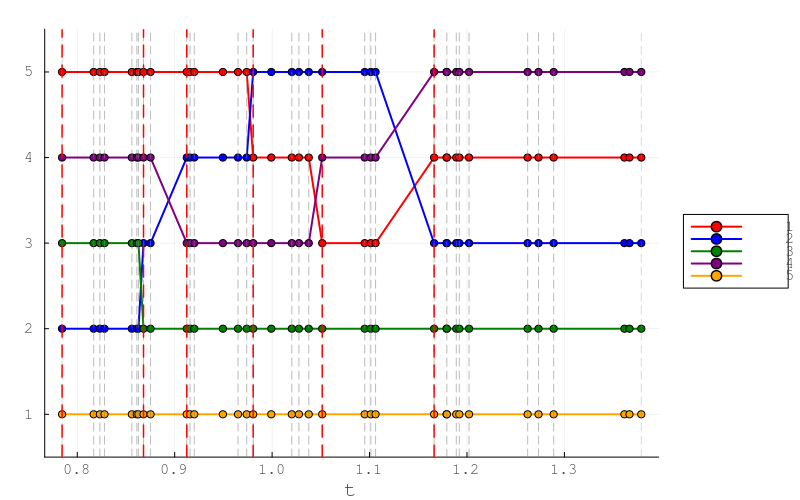

"/workspaces/inulab_julia_devcontainer/src/rank_changes_plot.png"

In [90]:
rank_plot = plot_rank_changes(results)
display(rank_plot)
savefig(rank_plot, "rank_changes_plot.png")

In [91]:
# 新しいCSV保存関数を呼び出す
if results !== nothing && hasfield(typeof(results), :rank_change_data)
   output_detailed_df = RankChangeInterval.save_rank_changes_and_rankings_to_csv(results, "rank_change_details.csv")
   display(output_detailed_df)
else
   println("結果に :rank_change_data フィールドが存在しないか、resultsがnothingです。")
end

Row,t_change_point,alt_1_rank,alt_2_rank,alt_3_rank,alt_4_rank,alt_5_rank
,Float64,Int64,Int64,Int64,Int64,Int64
1,0.784448,5,2,3,4,1
2,0.868028,5,3,2,4,1
3,0.912428,5,4,2,3,1
4,0.980565,4,5,2,3,1
5,1.05143,3,5,2,4,1
6,1.16627,4,3,2,5,1


In [47]:

output_df = save_results_to_csv(results)
display(output_df)

Row,t_point,alt_1,alt_2,alt_3,alt_4,alt_5
,Float64,Int64,Int64,Int64,Int64,Int64
1,0.784448,4,2,1,5,3
2,0.816865,4,3,2,5,1
3,0.823234,4,3,2,5,1
4,0.856067,4,3,2,5,1
5,0.868028,4,3,2,5,1
6,0.875224,4,3,2,5,1
7,0.912428,4,3,2,5,1
8,0.915771,4,3,2,5,1
9,0.956583,4,3,2,5,1


結果を rank_changes.csv に保存しました


最適t範囲: (0.7844484660502471, 1.378893823796674)


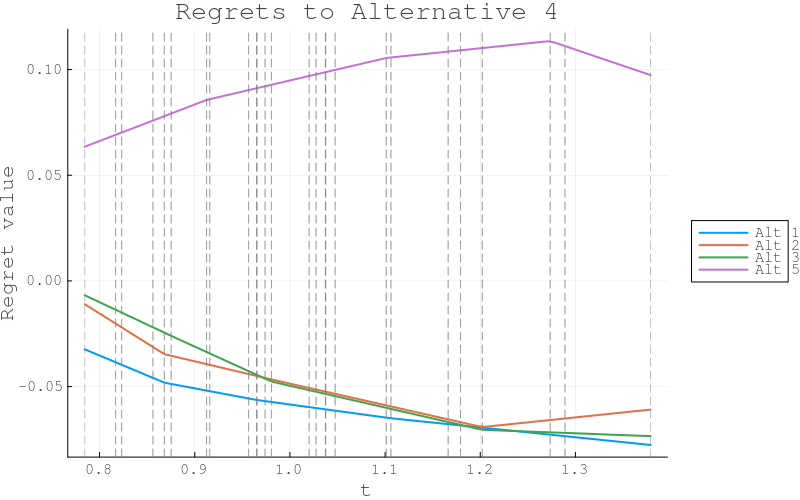

代替案 4 に対する最大リグレット分析:
----------------------------------------
t値　　　　最大リグレット　最大を与える代替案
----------------------------------------
1.378893823796674	0.09739990466190207	5 (初期値)

区間 1: [1.2889787163834352, 1.378893823796674]
最小アベイルスペース: 0.06975685965204997
この区間では最大リグレットを与える代替案は一定: 5
区間上端 t = 1.378893823796674 での最大リグレット: 0.09739990466190207 (代替案 5)
区間下端 t = 1.2889787163834352 での最大リグレット: 0.1111336589787679 (代替案 5)

区間 2: [1.2734327544732509, 1.2889787163834352]
最小アベイルスペース: 0.012207917422867587
この区間では最大リグレットを与える代替案は一定: 5
区間上端 t = 1.2889787163834352 での最大リグレット: 0.1111336589787679 (代替案 5)
区間下端 t = 1.2734327544732509 での最大リグレット: 0.11350817008859265 (代替案 5)

区間 3: [1.2021152419797878, 1.2734327544732509]
最小アベイルスペース: 0.059326685165399795
この区間では最大リグレットを与える代替案は一定: 5
区間上端 t = 1.2734327544732509 での最大リグレット: 0.11350817008859265 (代替案 5)
区間下端 t = 1.2021152419797878 での最大リグレット: 0.11019002698628505 (代替案 5)

区間 4: [1.1792953474439951, 1.2021152419797878]
最小アベイルスペース: 0.01935044905014882
この区間では最大リグレットを与える代替案は一定: 5

In [57]:
# 必要なパッケージを読み込む
using DelimitedFiles, DataFrames, CSV, Plots

# 前提として、以下のファイルが既に存在している
include("calc_IPW.jl")          # リグレット計算の基本関数
include("file_operate.jl")      # ファイル操作用関数
include("module_regret.jl")     # アベイルスペースに基づく順位変化計算

# 指定した代替案に対する最大リグレットの分析
function analyze_max_regret_for_alternative(o_o::Int, utility_data, method_weights, t_range)
    # 基本的なリグレット計算のためのマトリックス作成
    matrix = create_minimax_R_Matrix(utility_data)
    n = size(utility_data, 1)
    
    # アベイルスペースに基づく区間分割
    intervals = Tuple{Float64, Float64}[]
    current_t = t_range[2]  # t^Rから開始
    
    println("代替案 $o_o に対する最大リグレット分析:")
    println("----------------------------------------")
    println("t値　　　　最大リグレット　最大を与える代替案")
    println("----------------------------------------")
    
    # t^Rでの初期状態を確認
    tr_regrets = [regret_value(o_o, q, current_t, matrix, method_weights) for q in 1:n if q != o_o]
    tr_candidates = [q for q in 1:n if q != o_o]
    tr_max_idx = argmax(tr_regrets)
    tr_max_alt = tr_candidates[tr_max_idx]
    tr_max_value = tr_regrets[tr_max_idx]
    
    println("$current_t\t$tr_max_value\t$tr_max_alt (初期値)")
    
    # 区間ごとの分析
    interval_counter = 1
    
    while current_t > t_range[1]
        # アベイルスペースを計算して次のt値を決定
        Y_L = method_weights.L .* current_t
        Y_R = method_weights.R .* current_t
        
        temp_matrix = deepcopy(matrix)
        _, _ = calc_regret(temp_matrix, Y_L, Y_R)
        
        # 最小アベイルスペースを特定
        avail_spaces = [temp_matrix[i,j].Avail_space for i in 1:n, j in 1:n if i != j]
        min_avail = minimum(avail_spaces)
        
        # rパラメータとt'を計算
        r = 1 / (1 + min_avail)
        next_t = r * current_t
        next_t = max(next_t, t_range[1])  # t_Lより小さくならないように
        
        # 区間を記録
        push!(intervals, (next_t, current_t))
        
        println("\n区間 $interval_counter: [$next_t, $current_t]")
        println("最小アベイルスペース: $min_avail")
        
        # この区間での最大リグレットを与える代替案の変化を分析
        candidates = [q for q in 1:n if q != o_o]
        upper_regrets = [regret_value(o_o, q, current_t, matrix, method_weights) for q in candidates]
        lower_regrets = [regret_value(o_o, q, next_t, matrix, method_weights) for q in candidates]
        
        upper_max_idx = argmax(upper_regrets)
        upper_max_alt = candidates[upper_max_idx]
        upper_max_value = upper_regrets[upper_max_idx]
        
        lower_max_idx = argmax(lower_regrets)
        lower_max_alt = candidates[lower_max_idx]
        lower_max_value = lower_regrets[lower_max_idx]
        
        # 区間の両端で最大リグレットを与える代替案が変わる場合
        if upper_max_alt != lower_max_alt
            println("最大リグレットを与える代替案の変化を検出: $upper_max_alt → $lower_max_alt")
            
            # 交点を求める
            A_upper, B_upper = linear_regret_parameters(o_o, upper_max_alt, current_t, next_t, matrix, method_weights)
            A_lower, B_lower = linear_regret_parameters(o_o, lower_max_alt, current_t, next_t, matrix, method_weights)
            
            # 傾きが異なる場合のみ交点を計算
            if !isapprox(A_upper, A_lower, atol=1e-8)
                # r(t) = A*t + B の交点を計算
                t_cross = (B_lower - B_upper) / (A_upper - A_lower)
                
                # 区間内にあるか確認
                if t_cross >= next_t && t_cross <= current_t
                    # 交点での実際の最大リグレットを確認
                    t_cross_regrets = [regret_value(o_o, q, t_cross, matrix, method_weights) for q in candidates]
                    t_cross_max_idx = argmax(t_cross_regrets)
                    t_cross_max_alt = candidates[t_cross_max_idx]
                    t_cross_max_value = t_cross_regrets[t_cross_max_idx]
                    
                    println("交点 t = $t_cross で最大リグレット $t_cross_max_value を与えるのは代替案 $t_cross_max_alt")
                    
                    # すべての代替案のリグレット値を表示
                    println("交点でのリグレット値:")
                    for (idx, q) in enumerate(candidates)
                        println("  代替案 $q: $(t_cross_regrets[idx])")
                    end
                else
                    println("交点 t = $t_cross は区間外")
                end
            else
                println("両代替案のリグレット関数の傾きがほぼ等しい")
            end
        else
            println("この区間では最大リグレットを与える代替案は一定: $upper_max_alt")
        end
        
        println("区間上端 t = $current_t での最大リグレット: $upper_max_value (代替案 $upper_max_alt)")
        println("区間下端 t = $next_t での最大リグレット: $lower_max_value (代替案 $lower_max_alt)")
        
        # 次の区間へ
        current_t = next_t
        interval_counter += 1
        
        # t_Lに到達したら終了
        if isapprox(current_t, t_range[1], atol=1e-8)
            break
        end
    end
    
    # 区間データを返す
    return intervals
end

# リグレット関数のパラメータ（傾きと切片）を計算
function linear_regret_parameters(o_o::Int, q::Int, t1::Float64, t2::Float64, matrix, methodW)
    r1 = regret_value(o_o, q, t1, matrix, methodW)
    r2 = regret_value(o_o, q, t2, matrix, methodW)
    
    # 線形関数 r(t) = A*t + B のパラメータを計算
    A = (r2 - r1) / (t2 - t1)
    B = r1 - A*t1
    
    return A, B
end

# リグレット計算関数が実装されていなければ追加
function regret_value(o_o::Int, o_q::Int, t::Float64, matrix, methodW)
    if o_o == o_q
        return 0.0
    end
    
    Y_L = methodW.L .* t
    Y_R = methodW.R .* t
    
    # 一時的に regret を計算
    temp_matrix = deepcopy(matrix)
    _, _ = calc_regret(temp_matrix, Y_L, Y_R)
    
    # 行列内のリグレット値を取得
    i, j = minmax(o_o, o_q)
    if i == o_o
        return temp_matrix[i, j].regret
    else
        return -temp_matrix[i, j].regret  # 符号を反転
    end
end

# 実行部分
# データの読み込み
utility_data = read_utility_value()[1]  # 最初のデータセットを使用
method_weights = read_method_weights("A/MMRW", 1, 6)[1]  # 適切なパラメータに調整

# tの範囲計算
t_range = find_optimal_trange(method_weights.L, method_weights.R)
println("最適t範囲: ", t_range)

# 代替案1に対する分析
target_alt = 4
intervals = analyze_max_regret_for_alternative(target_alt, utility_data, method_weights, t_range)

# 結果のプロット（オプション）
# 各t値に対して代替案1へのリグレット値をプロット
t_values = range(t_range[1], t_range[2], length=100)
n = size(utility_data, 1)
candidates = [q for q in 1:n if q != target_alt]
matrix = create_minimax_R_Matrix(utility_data)

# 各代替案からのリグレット値を計算
regret_data = zeros(length(candidates), length(t_values))
for (i, q) in enumerate(candidates)
    for (j, t) in enumerate(t_values)
        regret_data[i, j] = regret_value(target_alt, q, t, matrix, method_weights)
    end
end

# プロット - 修正箇所
p = plot(
    t_values,
    regret_data',
    xlabel = "t",
    ylabel = "Regret value",
    title = "Regrets to Alternative $target_alt",
    label = permutedims(["Alt $q" for q in candidates]), # 修正: 転置の代わりにpermutedimsを使用
    linewidth = 2,
    legend = :outerright,
    size = (800, 500),
    grid = true
)

# 区間境界を表示
for (t_lower, t_upper) in intervals
    vline!([t_lower], linestyle = :dash, color = :gray, label = nothing, alpha = 0.5)
    vline!([t_upper], linestyle = :dash, color = :gray, label = nothing, alpha = 0.5)
end

display(p)